# Quora Insincere Question Classification

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0" #restart runtime after its done executing only if asked for.

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 41.0MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


### Mounting Google drive

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Import Libraries

In [ ]:
from fastai import *
from fastai.text import *

## Understanding the Problem statement

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

A key challenge is to weed out insincere questions -- those founded upon false premises, or **that intend to make a statement rather than look for helpful answers**.

We need to develop models that identify and flag insincere questions.

Competition Link: https://www.kaggle.com/c/quora-insincere-questions-classification/overview

### Preparing the data

In [ ]:
path = Path("gdrive/My Drive/data")

When you start off, it only contains one csv file, let's have a look at it.

For this, we use a framework of python called pandas (not fast.ai framework.  But, open source and widely used

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
df['question_text'][1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [ ]:
df.shape

(1306122, 3)

This is a large data set (roughly 13 lakhs or 1.3 million rows.  So, the execution takes a lot of time.  Be prepared to wait for 45-50 minutes for certain cells)

### Target Distribution

In [ ]:
df['target'].value_counts(normalize=True)*100

0    93.812982
1     6.187018
Name: target, dtype: float64

Such data sets where most data belongs to one class are biased and uneven.  You cannot use regular accuracy to measure how good a model is.  Let us go to ppt to discuss this aspect.

## Creating a TextDataBrunch

We can create a DataBunch containing this data in one line of code

In [ ]:
data_process = TextDataBunch.from_csv(path, 'train.csv', valid_pct=0.2, text_cols="question_text", label_cols="target")

Above line will start a lengthy process. Let's dig a bit into it. 

Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. 

A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: `tokenization` and `numericalization`.

Tokenization involves splitting sentences and compund words (eg. didn't) into words (did, n't), remove ultra rare words, marking interesting properties (initia character is capitalized etc.), removing punctuations, html code etc.

Numericalization then involves writing all the words in a alphabetical order and assigning one number to each word.

 A **`TextDataBunch`** does all of that behind the scenes for you.

In [ ]:
data_process.save('data_process.pkl')

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = load_data(path, 'data_process.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Defining Process

### Wikitext-103 - A language model [English Professor]

We can start by using a pre-trained language model Wikitext-103, which has been trained on all of the Wikipedia.

It is particularly useful for predicting next word of a sentence. But, normally its a model that understands a lot about English language.

### Quora Insincere Question - Transfer Learning [Quora Editor]

We can take the language model trained on wikitext-103 and use that as a transfer learning to create a new language model that’s specifically good at predicting the insincere questions

### Quora Insincere Question - Classifier [The Detective]

Use the fine tuned language model and build a classifier on top of it and it works perfectly fine

Before proceeding further, we’ll need to prepare our data for the language model and for the classification model separately.

In [ ]:
bs=48

## Preparing Language Model

Create a special kind of `TextDataBunch` suitable for training a language model.

All the texts in the datasets are concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

In [ ]:
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', valid_pct=0.2, text_cols="question_text", label_cols="target")
data_lm.save('data_lm.pkl')

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


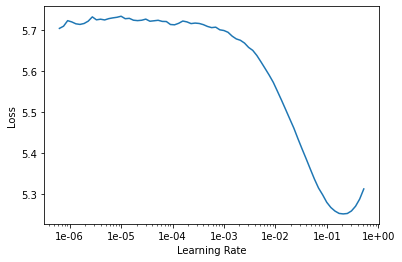

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2) #Rule of Thumb: 
#Choose lr 10x before min loss

epoch,train_loss,valid_loss,accuracy,time
0,3.705889,3.560578,0.382287,17:06


In [ ]:
learn.save('rough_fit')

In [ ]:
learn.load('rough_fit');

### Fine Tuning the Language Model
To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.551857,3.501776,0.392668,19:10
1,3.608279,3.540341,0.388442,19:12
2,3.487479,3.441820,0.398336,19:13
3,3.353637,3.334750,0.408455,19:07
4,3.227236,3.301899,0.412041,19:07


We have to save the encoding that the model gave (remember embeding and encoding?)

In [ ]:
learn.save('fine_tuned')
learn.load('fine_tuned');

In the language model, like any neural net, there are two parts: One to summarize (called encoder:  Review session 3 video if you do not remember) and one to predict.  As prediction (next word) is less important for us in this context, we save only the summarizer (we call it encoder).

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.
The vocab is important.  This model should exactly use the language model vocabularly.

In [ ]:
data_clas = (TextList.from_csv(path, 'train.csv', cols='question_text',vocab=data_lm.vocab)
                .split_by_rand_pct(0.1) 
                .label_from_df(cols=2)
                .databunch(bs=bs))
data_clas.save('tmp_clas')

In [ ]:
data_clas = load_data(path, 'tmp_clas', bs=bs)

### Create a Text Classifier Learner

We can then create a model to classify those questions and load the encoder(saved before) and relevant metrics

**Please use Encoder+Classifier as the architecture**

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1175510 items)
x: TextList
xxbos xxmaj do you have an adopted dog , how would you encourage people to adopt and not shop ?,xxbos xxmaj why does velocity affect time ? xxmaj does velocity affect space geometry ?,xxbos xxmaj how did xxmaj otto von xxmaj xxunk used the xxmaj magdeburg hemispheres ?,xxbos xxmaj can i convert montra xxunk d to a mountain bike by just changing the tyres ?,xxbos xxmaj why does xxmaj quora automatically ban conservative opinions when reported , but does not do the same for liberal views ?
y: CategoryList
0,0,0,0,0
Path: gdrive/My Drive/RWDS/ses04/data;

Valid: LabelList (130612 items)
x: TextList
xxbos xxmaj what is orthographic projection ?,xxbos xxmaj what percentage of vaginas smell like fish ?,xxbos xxmaj do we really need to learn xxmaj english ?,xxbos xxmaj what people like most in life ?,xxbos xxmaj how do some high school seniors score over 90 on the xxup asvab ? xxmaj they did research on mechanics

In [ ]:
learn.metrics=[accuracy, Precision(), Recall()]

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


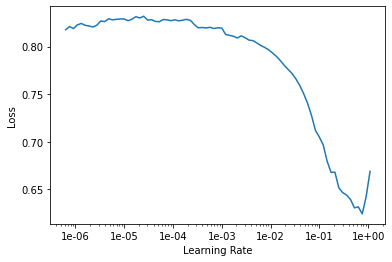

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.118961,0.122473,0.950916,0.687050,0.405566,07:33


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.120081,0.106447,0.957316,0.726868,0.516529,12:37


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.106984,0.105841,0.957569,0.745342,0.495868,17:51
1,0.120980,0.104650,0.958564,0.686096,0.630894,18:28


Buffered data was truncated after reaching the output size limit.

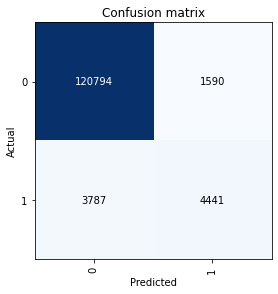

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Prediction on question

In [ ]:
learn.predict("Why is it that Trump supporters see him as a deity?")

(Category tensor(1), tensor(1), tensor([0.4076, 0.5924]))

In [ ]:
learn.predict("Have you ever babysitted a child whose parents were abusive?")

(Category tensor(0), tensor(0), tensor([0.9916, 0.0084]))